In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping,log_evaluation, Dataset, LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score,make_scorer 
from sklearn import set_config
import warnings

from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from time import time
from scipy.stats import kurtosis, skew, gmean, mode,trim_mean, mstats
from scipy.stats.mstats import winsorize
# Skopt functions


In [10]:
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

warnings.filterwarnings('ignore')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

ModuleNotFoundError: No module named 'skopt'

In [9]:
pip install skopt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

<Axes: >

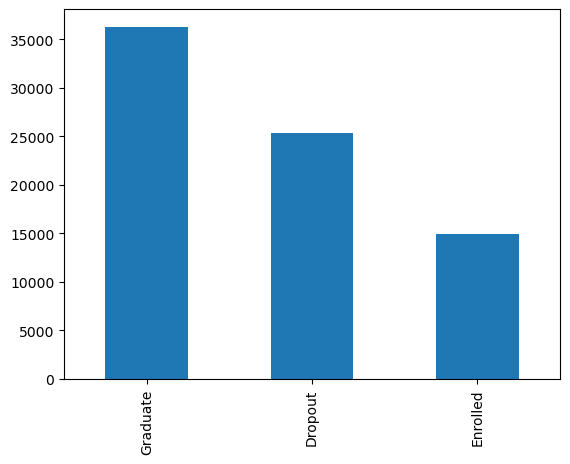

In [15]:
train.Target.value_counts().plot(kind='bar')

In [16]:
# The replacing of values is taken from following notebook
# https://www.kaggle.com/code/gauravduttakiit/pss4e6-flaml-roc-auc-ovo/notebook

class Model:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.model_dict = dict()
        self.test_predict_list = list()
     
    def preprocess(self):
        
        # https://www.kaggle.com/code/ambrosm/pss4e6-eda-which-makes-sense#Comparing-train,-test-and-the-original-data
#         cat_features = ['Marital status', 'Application mode', 'Course',
#                 'Previous qualification', 'Nacionality', "Mother's qualification", 
#                 "Father's qualification", "Mother's occupation",
#                 "Father's occupation"]
#         for feature in cat_features:
#             dtype = pd.CategoricalDtype(categories=list(set(self.train[feature]) | set(self.test[feature])), ordered=False)
#             for df in [self.train, self.test ]:
#                 df[feature] = df[feature].astype(dtype)
        self.train.Target = self.train.Target.map({"Graduate":0,
                                                  "Dropout":1,
                                                  "Enrolled":2})
#         self.train['Application mode']=self.train['Application mode'].replace({12:np.NaN,
#                                                            4:np.NaN,
#                                                             35:np.NaN,
#                                                             9:np.NaN,
#                                                             3:np.NaN}
#                                                            )
#         self.test['Application mode']=self.test['Application mode'].replace({14:np.NaN,
#                                                            35:np.NaN,
#                                                             19:np.NaN,
#                                                             3:np.NaN}
#                                                            )
#         self.train['Course']=self.train['Course'].replace({979:np.NaN,
#                                          39:np.NaN })
#         self.test['Course']=self.test['Course'].replace({7500:np.NaN,
#                                          9257:np.NaN,
#                                         2105:np.NaN,
#                                          4147:np.NaN,})
#         self.train['Previous qualification']=self.train['Previous qualification'].replace({37:np.NaN,
#                                          36:np.NaN, 
#                                         17:np.NaN,
#                                         11:np.NaN})
#         self.test['Previous qualification']=self.test['Previous qualification'].replace({17:np.NaN,
#                                                                        11:np.NaN,
#                                                                        16:np.NaN})
    
    def fit(self,params,name):
        target_col = ['Target']
        drop_col = ['id']
        self.preprocess()
        
        train_cols = [col for col in self.train.columns.to_list() if col not in target_col + drop_col]
        scores = list()
        
        
        for i in range(1):
            mskf = RepeatedKFold(n_splits=10, n_repeats=1,random_state=22)
            oof_valid_preds = np.zeros(self.train[train_cols].shape[0])
                
            for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[target_col])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[target_col].iloc[train_idx]
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[target_col].iloc[valid_idx]
                
                if name == 'lgbm':
                    early_stopping_callback = early_stopping(100,first_metric_only=True,verbose=False)
                    verbose_callback  = log_evaluation(125)
                    algo = LGBMClassifier(random_state=i+fold,**params)
                    algo.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                            callbacks=[early_stopping_callback,verbose_callback],eval_metric='multi_logloss')
                elif name== 'catboost':
                    algo = CatBoostlassifier(random_state=i+fold,**params)
                else:
                    algo = XGBClassifier(random_state=i+fold, missing=float('inf'),**params)
                    algo.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)
                    
                valid_preds = algo.predict(X_valid)
                oof_valid_preds[valid_idx] = valid_preds
                test_predict = algo.predict(self.test[train_cols])
                self.test_predict_list.append(test_predict)
                score = accuracy_score(y_valid, valid_preds)
                print(f"\nFold: {fold+1}\n===>Accuracy score: {score}")
                self.model_dict[f'fold_{fold}'] = algo
                    
            oof_score = accuracy_score(self.train[target_col], oof_valid_preds)
            print(f"The OOF accuracy score for iteration {i+1} is {oof_score}")
            scores.append(oof_score)
        predictions_3d = np.array(self.test_predict_list)

        # Perform majority voting to find the final prediction for each entry
        final_predictions = []
        for entry_predictions in predictions_3d.T:  # Iterate over each entry's predictions
            unique, counts = np.unique(entry_predictions, return_counts=True)
            final_predictions.append(unique[np.argmax(counts)])

        return final_predictions
    
    def report_perf(self,optimizer, X, y, title, callbacks=None):
        """
        A wrapper for measuring time and performances of different optmizers

        optimizer = a sklearn or a skopt optimizer
        X = the training set 
        y = our target
        title = a string label for the experiment
        """
        start = time()
        if callbacks:
            optimizer.fit(X, y, callback=callbacks)
        else:
            optimizer.fit(X, y)
        best_score = optimizer.best_score_
        best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
        best_params = optimizer.best_params_
        print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.6f "
               +u"\u00B1"+" %.6f") % (time() - start, 
                                      len(optimizer.cv_results_['params']),
                                      best_score,
                                      best_score_std))    
        print('Best parameters:')
        pprint(best_params)
        print()
        return best_params
    
    
    def find_params(self):
        self.preprocess()
        avg_acc = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)
        search_spaces = {
            'num_leaves': Integer(2, 210, prior='uniform'),
            'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
            'n_estimators': Integer(50, 1000, prior='uniform'),
            'subsample_for_bin': Integer(10000, 500000, prior='uniform'),
            'min_child_samples': Integer(1, 100, prior='uniform'),
            'reg_alpha': Real(1e-10, 1e-5, prior='log-uniform'),
            'reg_lambda': Real(1e-10, 1e-5, prior='log-uniform'),
            'colsample_bytree': Real(0.1, 0.9, prior='uniform'),
            'subsample': Real(0.5, 1.0, prior='uniform'),
            'max_depth': Integer(2, 20, prior='uniform')
        }
        skf = RepeatedKFold(n_splits=10, n_repeats=1,random_state=42)

        opt = BayesSearchCV(LGBMClassifier(verbosity=-1,device='gpu'),
                    search_spaces,
                    scoring=avg_acc,
                    cv=skf,
                    n_iter=10000,
                    n_jobs=1,  
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
        target_col = ['Target']
        drop_col = ['id']
        train_cols = [col for col in self.train.columns.to_list() if col not in target_col + drop_col]
        X = self.train[train_cols]
        y = self.train[target_col]
        best_params = self.report_perf(opt, X, y,'LightBoost', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*60*11)])

In [17]:
# https://www.kaggle.com/code/aspillai/academic-dataset-lightgbm-0-83767
lgbm_params = {'n_estimators': 8000, 
          'num_class': 3,
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'verbosity': -1,
          #'random_state': 99, 
          'reg_alpha': 1.7878527151970849, 
          'reg_lambda': 1.391543710164331, 
          'colsample_bytree': 0.5, 
          'subsample': 0.5, 
          'learning_rate': 0.04, 
          'max_depth': 20, 
          'num_leaves': 70, 
          'min_child_samples': 40, 
          'min_data_per_groups': 16,
          'device':'gpu',
          "extra_trees": True
    }

In [ ]:
model = Model(train,test)
lgbm_preds = model.fit(lgbm_params,'lgbm')

C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[125]	valid_0's multi_logloss: 0.478202
[250]	valid_0's multi_logloss: 0.451496
[375]	valid_0's multi_logloss: 0.441947
[500]	valid_0's multi_logloss: 0.437736
[625]	valid_0's multi_logloss: 0.435089
[750]	valid_0's multi_logloss: 0.433196
[875]	valid_0's multi_logloss: 0.431753
[1000]	valid_0's multi_logloss: 0.430672
[1125]	valid_0's multi_logloss: 0.429789
[1250]	valid_0's multi_logloss: 0.4289
[1375]	valid_0's multi_logloss: 0.428238
[1500]	valid_0's multi_logloss: 0.427871
[1625]	valid_0's multi_logloss: 0.427447
[1750]	valid_0's multi_logloss: 0.427078
[1875]	valid_0's multi_logloss: 0.426829
[2000]	valid_0's multi_logloss: 0.426565
[2125]	valid_0's multi_logloss: 0.426287
[2250]	valid_0's multi_logloss: 0.426041
[2375]	valid_0's multi_logloss: 0.425804
[2500]	valid_0's multi_logloss: 0.425742
[2625]	valid_0's multi_logloss: 0.425629
[2750]	valid_0's multi_logloss: 0.425475
[2875]	valid_0's multi_logloss: 0.425418
[3000]	valid_0's multi_logloss: 0.425299
[3125]	valid_0's multi_lo

C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[125]	valid_0's multi_logloss: 0.476629
[250]	valid_0's multi_logloss: 0.454532
[375]	valid_0's multi_logloss: 0.447793
[500]	valid_0's multi_logloss: 0.444231
[625]	valid_0's multi_logloss: 0.441943
[750]	valid_0's multi_logloss: 0.440349
[875]	valid_0's multi_logloss: 0.439175
[1000]	valid_0's multi_logloss: 0.438132
[1125]	valid_0's multi_logloss: 0.437341
[1250]	valid_0's multi_logloss: 0.436731
[1375]	valid_0's multi_logloss: 0.436205
[1500]	valid_0's multi_logloss: 0.435938
[1625]	valid_0's multi_logloss: 0.435612
[1750]	valid_0's multi_logloss: 0.435215
[1875]	valid_0's multi_logloss: 0.435006
[2000]	valid_0's multi_logloss: 0.434955

Fold: 2
===>Accuracy score: 0.8328541557762676


C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[125]	valid_0's multi_logloss: 0.468209
[250]	valid_0's multi_logloss: 0.447746
[375]	valid_0's multi_logloss: 0.440425
[500]	valid_0's multi_logloss: 0.436694
[625]	valid_0's multi_logloss: 0.434573
[750]	valid_0's multi_logloss: 0.432875
[875]	valid_0's multi_logloss: 0.431729
[1000]	valid_0's multi_logloss: 0.430705
[1125]	valid_0's multi_logloss: 0.429992
[1250]	valid_0's multi_logloss: 0.429218
[1375]	valid_0's multi_logloss: 0.428764
[1500]	valid_0's multi_logloss: 0.428411
[1625]	valid_0's multi_logloss: 0.42788
[1750]	valid_0's multi_logloss: 0.427602
[1875]	valid_0's multi_logloss: 0.427355
[2000]	valid_0's multi_logloss: 0.427073
[2125]	valid_0's multi_logloss: 0.426881
[2250]	valid_0's multi_logloss: 0.426636
[2375]	valid_0's multi_logloss: 0.426458
[2500]	valid_0's multi_logloss: 0.426279
[2625]	valid_0's multi_logloss: 0.426273
[2750]	valid_0's multi_logloss: 0.426189
[2875]	valid_0's multi_logloss: 0.426097
[3000]	valid_0's multi_logloss: 0.425909
[3125]	valid_0's multi_l

C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[125]	valid_0's multi_logloss: 0.474146
[250]	valid_0's multi_logloss: 0.452069
[375]	valid_0's multi_logloss: 0.444572
[500]	valid_0's multi_logloss: 0.440951
[625]	valid_0's multi_logloss: 0.438735
[750]	valid_0's multi_logloss: 0.437349
[875]	valid_0's multi_logloss: 0.436258
[1000]	valid_0's multi_logloss: 0.43548
[1125]	valid_0's multi_logloss: 0.434917
[1250]	valid_0's multi_logloss: 0.434579
[1375]	valid_0's multi_logloss: 0.434172
[1500]	valid_0's multi_logloss: 0.433857
[1625]	valid_0's multi_logloss: 0.433657
[1750]	valid_0's multi_logloss: 0.433551
[1875]	valid_0's multi_logloss: 0.433421
[2000]	valid_0's multi_logloss: 0.433205
[2125]	valid_0's multi_logloss: 0.433146
[2250]	valid_0's multi_logloss: 0.43306
[2375]	valid_0's multi_logloss: 0.432918
[2500]	valid_0's multi_logloss: 0.432849
[2625]	valid_0's multi_logloss: 0.432748
[2750]	valid_0's multi_logloss: 0.432658
[2875]	valid_0's multi_logloss: 0.432608
[3000]	valid_0's multi_logloss: 0.432534
[3125]	valid_0's multi_lo

In [7]:
label_mapping = {
    0: "Graduate",
    1: "Dropout",
    2: "Enrolled"
}
predicted_labels = [label_mapping[value] for value in lgbm_preds]

In [8]:
submit = pd.read_csv('sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout
